# Analyzing New York City High School Data

In this data cleaning project, we'll take a look at whether standardized tests like the SAT are unfair to certain demographics by investigating the correlations between SAT scores in New York City––NYC––high schools.

The [SAT](https://en.wikipedia.org/wiki/SAT)––Scholastic Aptitude Test––is the most prevalent standardized exam that U.S. high school students take before applying for college, as it is frequently used by universities to assess college admissions. The test comprises three sections, each with a possible 800 points for a combined 2,400 possible points. Scoring well can be very important for students competing to get into top-tier universities, but the average scores are also often used to rank each high school and measure the overall school district quality.

For our analysis, we'll be using several datasets containing demographic information and test scores for New York Ciry high schools. In the first part of this project, we'll have to clean up and combine our datasets. Here are links to the datasets we will be using:

* [SAT Scores by School](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school
* [School Attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance data for each school
* [Class Size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
* [AP Test Results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school
* [Graduation Outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - Percentage of students who graduated
* [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
* [All Schools & D75 Survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

There are a few important things to know if you're not completely familiar with how the school system in NYC works. First is that only high school students take the SAT, so we'll only use high school data from our datasets. There are five boroughs in NYC, and each school has a unique DBN––district borough number. Each school falls within one of several school districts, so this can allow us to do things like mapping and comparing data for each district.


## Import Libraries & Reading in the Data

We'll read each file in our `schools` folder into a pandas dataframe, and then for convenience we'll store the dataframes in a dictionary so that we can quickly reference them later on.

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline

# Reading in the csv files
data_files = [
    'ap_2010.csv',
    'class_size.csv',
    'demographics.csv',
    'graduation.csv',
    'hs_directory.csv',
    'sat_results.csv'
]

data = {}

for file in data_files:
    d = pd.read_csv('schools/{0}'.format(file))
    key_name = file.replace('.csv', '')
    data[key_name] = d
    
# Reading in the txt survey files
all_survey = pd.read_csv('schools/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0) # Combines the 2 surveys into a single dataframe

## Fix the DBN Columns

The DBN is a unique ID for each school, and each DBN is unique in the SAT data. We'll be using this column to help us combine our datasets. In the `sat_results` data, there is no DBN, but we can combine the CSD and SCHOOL CODE columns in the class_size data, so we'll have to fix this before being able to do our analysis.

In [2]:
survey['DBN'] = survey['dbn']

survey_fields = [
    'DBN', 
    'rr_s', 
    'rr_t', 
    'rr_p', 
    'N_s', 
    'N_t', 
    'N_p', 
    'saf_p_11', 
    'com_p_11', 
    'eng_p_11', 
    'aca_p_11', 
    'saf_t_11', 
    'com_t_11', 
    'eng_t_11', 
    'aca_t_11', 
    'saf_s_11', 
    'com_s_11', 
    'eng_s_11', 
    'aca_s_11', 
    'saf_tot_11', 
    'com_tot_11', 
    'eng_tot_11', 
    'aca_tot_11',
]
survey = survey[survey_fields]
data['survey'] = survey

In [3]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return '0' + string_representation
    
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

## Convert Columns to Numeric

Here we convert some of our columns to numeric columns, and we use RegEx to extract our latitudinal and longitudinal data into their own columns.

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data['sat_results'][c] = pd.to_numeric(data['sat_results'][c], errors='coerce')

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lat = coords[0].split(",")[0].replace('(', '')
    return lat

def find_lon(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lon = coords[0].split(',')[1].replace(')', '').strip()
    return lon

data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(find_lat)
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(find_lon)

data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')

## Condense the Datasets

Some of our datasets have unique DBN values, however, `class_size`, `graduation`, and `demographics` have duplicate DBN values, so we'll need to condense these datasets so that each value in the DBN column is unique in order to be able to combine the datasets later on.

In [5]:
# Filtering the data to contain only high school and general education classes
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']
# Taking the average across all classes the school offers to produce unique DBN values
class_size = class_size.groupby('DBN').agg(numpy.mean)
class_size.reset_index(inplace=True)
data['class_size'] = class_size

# Select rows where schoolyear is 20112012 to give us the most recent year of data and unique DBN values
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

# Selecting data from only the most recent total cohort to have unique DBN values
data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

## Convert AP Scores to Numeric

Next we need to convert the AP exam scores in the `ap_2010` data set to numeric values so we can look at whether or not AP exam scores correlate with SAT scores.

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors='coerce')

## Combine the Datasets

We're finally ready to combine all of our data sets. We'll use the DBN column to identify matching rows across our data sets and then merge them.

In [7]:
combined = data['sat_results']

combined = combined.merge(data['ap_2010'], on='DBN', how='left')
combined = combined.merge(data['graduation'], on='DBN', how='left')

to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']

for m in to_merge:
    combined = combined.merge(data[m], on='DBN', how='inner')

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add School District Column for Mapping

Now that our data is cleaned and combined, we'll want to maybe map the statistics out on a school distric level. To help us accomplish this, we'll add a column to our newly created dataset that specifies the school district.

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined['school_dist'] = combined['DBN'].apply(get_first_two_chars)

## Find and Plot Correlations

It can help us with our analysis if we know how closely related two columns are, so we'll be looking at that here.

In [9]:
correlations = combined.corr()
correlations = correlations['sat_score']
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove('DBN')

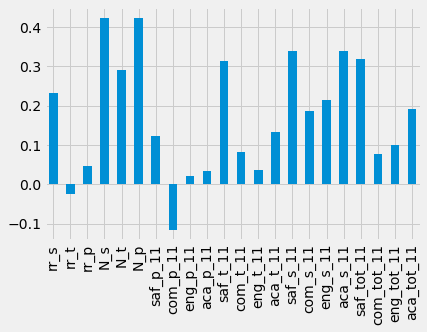

In [11]:
plt.style.use('fivethirtyeight')
combined.corr()['sat_score'][survey_fields].plot.bar()

`N_s`, `N_t`, `N_p`, and `sat_score` are highly correlated, and these columns are also all correlated with `total_enrollment`. It also looks like perceived safety are correlated with `sat_score`. `aca_s_11`, which indicates how the student perceives academic standards, is also correlated with `sat_score`. Interestingly enough the teachers or parents perceptions in `aca_t_11` and `aca_p_11` are not correlated with `sat_score`.

## Exploring Safety

We'll explore one of the correlations we found above, and see if there is more behind perceived safety and SAT scores.

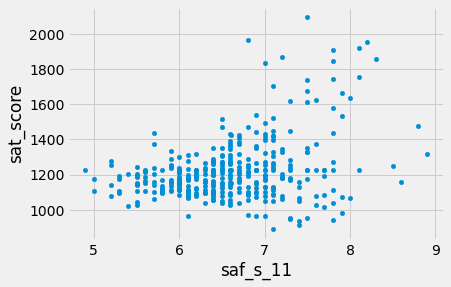

In [12]:
combined.plot.scatter('saf_s_11', 'sat_score')

Mapping Safety

In [13]:
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


OSError: Unable to open boundary dataset file. Only the 'crude' and  'low',
resolution datasets are installed by default.
If you are requesting an, 'intermediate', 'high' or 'full'
resolution dataset, you may need to download and install those
files separately with
`conda install basemap-data-hires`.

## Racial Differences

We have some columns that indicate the percentage of each race at a given school. We'll plot out the correlations between these columns and sat_score so we can determine if there are any racial differences in SAT performance.

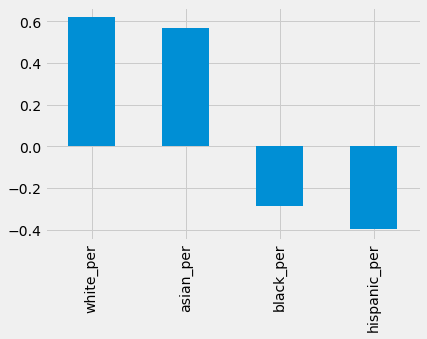

In [14]:
race_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'][race_fields].plot.bar()

White and asian students correlate positively with sat_score, and black and hispanic correlate negatively with sat_score. These correlations could be due to lack of school funding in for schools in certain areas where there is a higher percentage of black or hispanic students. Let's look into it further.

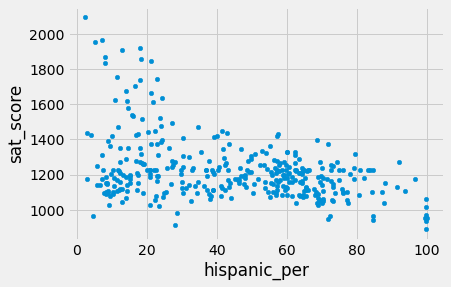

In [23]:
# Schools with low SAT scores and high values for hispanic_per
combined.plot.scatter('hispanic_per', 'sat_score')

In [22]:
# Schools with a hispanic_per greater than 95%
print(combined[combined['hispanic_per'] > 95]['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


After looking up the schools listed above, we can see that these schools have a lot of immigrant students who are learning English, so the lower SAT scores are understandable.

In [24]:
# Schools with a hispanic_per less than 10% and an average SAT score greater than 1800
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools listed above are specialized STEM schools that only admit students who pass an entrance exam, so these students have already performed well on a standardized test, which explains the generally higher SAT scores.

## Gender Differences

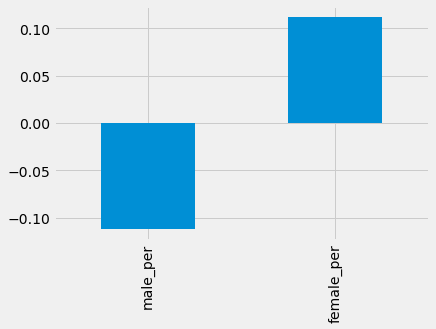

In [26]:
gender_fields = ['male_per', 'female_per']
combined.corr()['sat_score'][gender_fields].plot.bar()

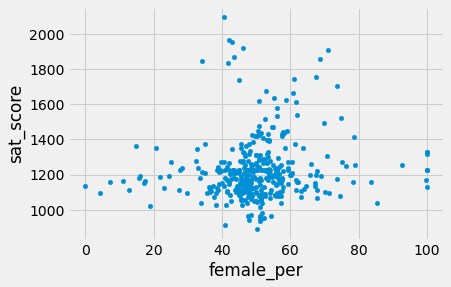

In [27]:
combined.plot.scatter('female_per', 'sat_score')

Explain.

In [29]:
print(combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


## SAT Scores & AP Exam Scores

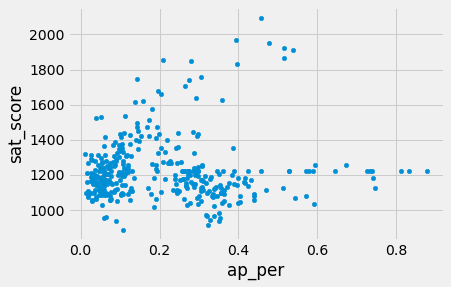

In [28]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score')

## Conclusion & Next Steps

In this project we investigated New York City high school data for relationships between demographics and SAT scores. 

Some next steps we could take to continue our analysis could be to look at:

* Determining if there's a correlation between class size and SAT scores
* Looking at which neighborhoods have the best schools
* Combining our dataset with property values to find the least expensive neighborhoods witht the best schools
* The differences between parent, teacher, and student responses to the surveys.
* Assigning scores to each school based on the SAT scores and other attributes

The idea for this project comes from the [DATAQUEST](https://app.dataquest.io/) **Data Cleaning** course.